# LangGraphStudio - MultiAgent

- Author: [Taylor(Jihyun Kim)](https://github.com/Taylor0819)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/20-Multi-AgentWorkflowUsingLangGraphStudio.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/20-Multi-AgentWorkflowUsingLangGraphStudio.ipynb)



## Overview

This notebook demonstrates how to efficiently gather and analyze information about a specific person.  
We begin by using a `QUERY_WRITER_PROMPT` to automatically generate targeted search queries, helping you quickly collect relevant data on a given individual.  
Next, we utilize the `DEFAULT_EXTRACTION_SCHEMA` to define how to structure extracted data (e.g., `role`, `years_experience`, `current_company`, `prior_companies`), ensuring consistency and clarity.

The notebook then introduces how to integrate `LangChain` and `LangGraph Studio` to orchestrate multi-step processes:
- **LangChain**: A framework that leverages large language models (LLMs) for tasks such as query generation, data extraction, and workflow automation.
- **LangGraph Studio**: A tool that visualizes and debugs your agent pipelines, making it easier to design and maintain complex workflows.

This notebook covers the following key points:
1. **Automated Query Generation**  
   Learn how to create highly focused search queries that maximize the chance of finding relevant information on the person.
2. **Data Schema Definition**  
   Use a Pydantic-based JSON schema to structure and validate the person’s information, including role, work experience, and company details.
3. **Multi-Agent Workflow**  
   Connect multiple agents (e.g., one for generating queries, another for parsing and validating the results) in a streamlined process, and visualize these connections using LangGraph Studio.

![Langgraph Studio](./assets/20-LangGraphStudio-MultiAgent-01.png)

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [What is LangGraph Studio](#what-is-langgraph-studio)
- [Building a Persona Chatbot](#building-a-persona-chatbot)
- [How to connect a local agent to LangGraph Studio](#how-to-connect-a-local-agent-to-langgraph-studio)


### References
- [LangGraph Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)
----

## Environment Setup
Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]** 

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [103]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [104]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["langsmith", "langchain_anthropic", "langgraph", "tavily-python"],
    verbose=False,
    upgrade=False,
)

In [105]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "ANTHROPIC_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "20-Multi-AgentWorkflowUsingLangGraphStudio",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `ANTHROPIC_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [106]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [107]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_anthropic import ChatAnthropic

rate_limiter = InMemoryRateLimiter(
    requests_per_second=4,
    check_every_n_seconds=0.1,
    max_bucket_size=10,  # Controls the maximum burst size.
)

llm = ChatAnthropic(
    model="claude-3-5-sonnet-latest", temperature=0, rate_limiter=rate_limiter
)

In [108]:
### Get tavil api key
from tavily import AsyncTavilyClient
# Search
tavily_async_client = AsyncTavilyClient()


In [109]:
from dataclasses import dataclass, field
from typing import Any, Optional, Annotated
from pydantic import BaseModel, Field
import operator
from pydantic import BaseModel

DEFAULT_EXTRACTION_SCHEMA = {
    "type": "object",
    "required": [
        "years_experience",
        "current_company",
        "role",
        "prior_companies",
    ],
    "properties": {
        "role": {"type": "string", "description": "Current role of the person."},
        "years_experience": {
            "type": "number",
            "description": "How many years of full time work experience (excluding internships) does this person have.",
        },
        "current_company": {
            "type": "string",
            "description": "The name of the current company the person works at.",
        },
        "prior_companies": {
            "type": "array",
            "items": {"type": "string"},
            "description": "List of previous companies where the person has worked",
        },
    },
    "description": "Person information",
    "title": "Person",
}

In [110]:
class Person(BaseModel):
    """A class representing a person to research."""

    name: Optional[str] = None
    """The name of the person."""
    company: Optional[str] = None
    """The current company of the person."""
    linkedin: Optional[str] = None
    """The Linkedin URL of the person."""
    email: str
    """The email of the person."""
    role: Optional[str] = None
    """The current title of the person."""

@dataclass(kw_only=True)
class InputState:
    """Input state defines the interface between the graph and the user (external API)."""

    person: Person
    "Person to research."

    extraction_schema: dict[str, Any] = field(
        default_factory=lambda: DEFAULT_EXTRACTION_SCHEMA
    )
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: Optional[dict[str, Any]] = field(default=None)
    "Any notes from the user to start the research process."


@dataclass(kw_only=True)
class OverallState:
    """Input state defines the interface between the graph and the user (external API)."""

    person: Person
    "Person to research provided by the user."

    extraction_schema: dict[str, Any] = field(
        default_factory=lambda: DEFAULT_EXTRACTION_SCHEMA
    )
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: str = field(default=None)
    "Any notes from the user to start the research process."

    search_queries: list[str] = field(default=None)
    "List of generated search queries to find relevant information"

    # Add default values for required fields
    completed_notes: Annotated[list, operator.add] = field(default_factory=list)
    "Notes from completed research related to the schema"

    info: dict[str, Any] = field(default=None)
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """

    Questions: list[str] = field(default=None)

    is_satisfactory: bool = field(default=None)
    "True if all required fields are well populated, False otherwise"

    reflection_steps_taken: int = field(default=0)
    "Number of times the reflection node has been executed"


@dataclass(kw_only=True)
class OutputState:
    """The response object for the end user.

    This class defines the structure of the output that will be provided
    to the user after the graph's execution is complete.
    """

    info: dict[str, Any]
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """



In [111]:
class Queries(BaseModel):
    queries: list[str] = Field(
        description="List of search queries.",
    )

class ReflectionOutput(BaseModel):
    is_satisfactory: bool = Field(
        description="True if all required fields are well populated, False otherwise"
    )
    missing_fields: list[str] = Field(
        description="List of field names that are missing or incomplete"
    )
    search_queries: list[str] = Field(
        description="If is_satisfactory is False, provide 1-3 targeted search queries to find the missing information"
    )
    reasoning: str = Field(description="Brief explanation of the assessment")

In [112]:
def deduplicate_and_format_sources(
    search_response, max_tokens_per_source, include_raw_content=True
):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response["results"]
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and "results" in response:
                sources_list.extend(response["results"])
            else:
                sources_list.extend(response)
    else:
        raise ValueError(
            "Input must be either a dict with 'results' or a list of search results"
        )

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source["url"] not in unique_sources:
            unique_sources[source["url"]] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += (
            f"Most relevant content from source: {source['content']}\n===\n"
        )
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get("raw_content", "")
            if raw_content is None:
                raw_content = ""
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()


def format_all_notes(completed_notes: list[str]) -> str:
    """Format a list of notes into a string"""
    formatted_str = ""
    for idx, people_notes in enumerate(completed_notes, 1):
        formatted_str += f"""
{'='*60}
People {idx}:
{'='*60}
Notes from research:
{people_notes}"""
    return formatted_str

In [113]:
import os
from dataclasses import dataclass, fields
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig


@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""

    max_search_queries: int = 3  # Max search queries per person
    max_search_results: int = 3  # Max search results per query
    max_reflection_steps: int = 0  # Max reflection steps

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

In [114]:
QUERY_WRITER_PROMPT = """You are a search query generator tasked with creating targeted search queries to gather specific information about a person.

Here is the person you are researching: {person}

Generate at most {max_search_queries} search queries that will help gather the following information:

<schema>
{info}
</schema>

<user_notes>
{user_notes}
</user_notes>

Your query should:
1. Make sure to look up the right name
2. Use context clues as to the company the person works at (if it isn't concretely provided)
3. Do not hallucinate search terms that will make you miss the persons profile entirely
4. Take advantage of the Linkedin URL if it exists, you can include the raw URL in your search query as that will lead you to the correct page guaranteed.

Create a focused query that will maximize the chances of finding schema-relevant information about the person.
Remember we are interested in determining their work experience mainly."""


In [115]:
# generate queries
from langchain_core.runnables import RunnableConfig

def generate_queries(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """Generate search queries based on the user input and extraction schema."""
    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    max_search_queries = configurable.max_search_queries

    # Generate search queries
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    person_str = f"Email: {state.person['email']}"
    if "name" in state.person:
        person_str += f" Name: {state.person['name']}"
    if "linkedin" in state.person:
        person_str += f" LinkedIn URL: {state.person['linkedin']}"
    if "role" in state.person:
        person_str += f" Role: {state.person['role']}"
    if "company" in state.person:
        person_str += f" Company: {state.person['company']}"

    query_instructions = QUERY_WRITER_PROMPT.format(
        person=person_str,
        info=json.dumps(state.extraction_schema, indent=2),
        user_notes=state.user_notes,
        max_search_queries=max_search_queries,
    )

    # Generate queries
    results = cast(
        Queries,
        structured_llm.invoke(
            [
                {"role": "system", "content": query_instructions},
                {
                    "role": "user",
                    "content": "Please generate a list of search queries related to the schema that you want to populate.",
                },
            ]
        ),
    )

    # Queries
    query_list = [query for query in results.queries]
    return {"search_queries": query_list}


In [133]:
COMPANY_QUERY_WRITER_PROMPT = """You are a search query generator tasked with creating targeted search queries to gather specific information about a company.

Company name: {company_name}

We want to discover:
{company_info}

Also consider any user notes:
{user_notes}

Constraints:
1. Do not hallucinate search terms that are irrelevant or generic.
2. If the user provides pre-defined queries, try to integrate or refine them as needed.
3. Return at most {max_search_queries} unique and meaningful queries.
"""

In [134]:
async def generate_queries_for_company(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Generate search queries specifically for the company, 
    possibly merging with user-provided queries (company_queries in state).
    """

    # 1) 기본 설정값 로딩
    configurable = Configuration.from_runnable_config(config)
    max_search_queries = configurable.max_search_queries

    # 2) 사용자가 직접 넣은 쿼리가 있으면 미리 확보
    #    예: state.company_queries = ["Some user-defined query for the company"]
    user_defined_queries = getattr(state, "company_queries", [])

    # 3) 회사 이름, 조사 스키마, user_notes 등 준비
    company_name = state.person.get("company", "Unknown Company")
    company_info_schema = {
        "fields": ["company_overview", "products", "latest_news"]  # 예시
    }
    # 예: json.dumps(...)로 구조화된 조사 목표를 간단히 만들거나,
    #    실제로는 별도 state.extraction_schema_company 같은 것을 둘 수도 있음
    company_info_str = json.dumps(company_info_schema, indent=2)

    # user_notes를 추가로 고려 (없으면 빈 문자열)
    user_notes = state.user_notes if state.user_notes else ""

    # 4) LLM에 쿼리 생성을 요청
    structured_llm = llm.with_structured_output(Queries)  # Queries: pydantic model for array of strings

    prompt = COMPANY_QUERY_WRITER_PROMPT.format(
        company_name=company_name,
        company_info=company_info_str,
        user_notes=user_notes,
        max_search_queries=max_search_queries,
    )

    # 5) LLM 호출 (비동기)
    llm_result = cast(
        Queries,
        await structured_llm.ainvoke(
            [
                {"role": "system", "content": prompt},
                {
                    "role": "user",
                    "content": "Generate company-related search queries now.",
                },
            ]
        )
    )

    # 6) LLM이 생성한 쿼리를 리스트로 변환
    generated_queries = [q for q in llm_result.queries]

    # 7) 만약 사용자 정의 쿼리가 있다면, 둘을 합쳐서 중복 제거
    all_queries = set(user_defined_queries + generated_queries)
    
    # 필요하다면 중복 제거, 제한된 길이로 조정
    final_queries = list(all_queries)[:max_search_queries]

    # 8) 반환
    return {"company_search_queries": final_queries}

In [135]:
async def research_company(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Use 'company_search_queries' to search relevant info about the company,
    then produce 'company_notes'.
    """
    # 1) 병합된 쿼리 가져오기
    company_search_queries = getattr(state, "company_search_queries", [])
    if not company_search_queries:
        return {"company_notes": "No company_search_queries found. Please run generate_queries_for_company first."}

    notes = []
    # 2) 실제 검색
    for query in company_search_queries:
        search_result = await tavily_async_client.search(
            query, 
            max_results=3,
            topic="company"
        )
        notes.append(str(search_result))  # 간단히 문자열로 저장

    # 3) LLM 요약 or 단순 연결
    company_notes_str = "\n\n".join(notes)
    return {"company_notes": company_notes_str}

In [116]:
INFO_PROMPT = """You are doing web research on people, {people}. 

The following schema shows the type of information we're interested in:

<schema>
{info}
</schema>

You have just scraped website content. Your task is to take clear, organized notes about a person, focusing on topics relevant to our interests.

<Website contents>
{content}
</Website contents>

Here are any additional notes from the user:
<user_notes>
{user_notes}
</user_notes>

Please provide detailed research notes that:
1. Are well-organized and easy to read
2. Focus on topics mentioned in the schema
3. Include specific facts, dates, and figures when available
4. Maintain accuracy of the original content
5. Note when important information appears to be missing or unclear

Remember: Don't try to format the output to match the schema - just take clear notes that capture all relevant information."""


In [117]:
async def research_person(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """Execute a multi-step web search and information extraction process.

    This function performs the following steps:
    1. Executes concurrent web searches using the Tavily API
    2. Deduplicates and formats the search results
    """

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    max_search_results = configurable.max_search_results

    # Web search
    search_tasks = []
    for query in state.search_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                days=360,
                max_results=max_search_results,
                include_raw_content=True,
                topic="general",
            )
        )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(
        search_docs, max_tokens_per_source=1000, include_raw_content=True
    )

    # Generate structured notes relevant to the extraction schema
    p = INFO_PROMPT.format(
        info=json.dumps(state.extraction_schema, indent=2),
        content=source_str,
        people=state.person,
        user_notes=state.user_notes,
    )
    result = await llm.ainvoke(p)
    return {"completed_notes": [str(result.content)]}


In [118]:
PROJECT_INFO_PROMPT = """You are doing additional web research on projects by {people}.

Focus on details about important projects they have worked on. Gather:
- project name
- relevant context or goals
- timeline
- major accomplishments
- technologies used
- challenges faced

Website contents:
{content}

Return your notes in a well-structured format that could be used for interview preparation.
"""

In [119]:
async def research_projects(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Execute a multi-step web search focusing on the person's projects,
    then summarize the findings in a well-structured format.
    """

    configurable = Configuration.from_runnable_config(config)
    max_search_results = configurable.max_search_results

    # 예: 기존에 person 검색어 + "project" 같은 키워드를 자동 생성하는 로직
    # 간단 예시: person 이름만 있다면
    project_queries = [
        f"{state.person} project",
        f"{state.person} case study",
        f"{state.person} portfolio",
    ]
    if hasattr(state, "user_notes") and state.user_notes:
        # user_notes에 특정 프로젝트 명이 언급되어 있다면 추가
        project_queries.append(f"{state.person} {state.user_notes} project")

    # Web search (concurrent)
    search_tasks = []
    for query in project_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                days=360,
                max_results=max_search_results,
                include_raw_content=True,
                topic="general",
            )
        )

    # Execute all searches concurrently
    search_results = await asyncio.gather(*search_tasks)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(
        search_results, max_tokens_per_source=1000, include_raw_content=True
    )

    # Use LLM to organize the project-related notes
    prompt = PROJECT_INFO_PROMPT.format(
        people=state.person,
        content=source_str
    )
    llm_result = await llm.ainvoke(prompt)

    return {"project_notes": str(llm_result.content)}



In [132]:
COMBINE_ALL_PROMPT = """We have three sets of notes:

1) Person Notes:
{person_notes}

2) Company Notes:
{company_notes}

3) Project Notes:
{project_notes}

Please merge these notes into a single coherent summary. 
Remove any duplicate or conflicting information. 
The result should flow logically, covering person's details, the company background, and key project info.
"""

async def combine_notes(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Merge the notes from research_person (person_notes) and research_projects (project_notes)
    into a single cohesive note.
    """
    person_notes = getattr(state, "person_notes", "")
    company_notes = getattr(state, "company_notes", "")
    project_notes = getattr(state, "project_notes", "")

    # 만약 LLM 객체가 llm이라는 이름으로 존재한다고 가정
    prompt = COMBINE_NOTES_PROMPT.format(
        person_notes=person_notes,
        project_notes=project_notes,
    )
    llm_result = await llm.ainvoke(prompt)  # llm은 상위 스코프에서 선언된 LangChain LLM

    return {"combined_notes": str(llm_result.content)}

In [121]:
GENERATE_QUESTIONS_PROMPT = """Based on the following combined note:
{combined_notes}

Create a list of interview questions that focus on this person's experiences, 
skills, and the project/product details mentioned. Format them as:
Q1: ...
Q2: ...
Q3: ...
"""

async def generate_questions(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Use the combined notes to generate a set of interview questions.
    """
    combined_notes = getattr(state, "combined_notes", "")
    if not combined_notes:
        return {"interview_questions": "No combined notes available. Please run combine_notes first."}

    prompt = GENERATE_QUESTIONS_PROMPT.format(
        combined_notes=combined_notes
    )
    llm_result = await llm.ainvoke(prompt)

    return {"interview_questions": str(llm_result.content)}

In [122]:
REFLECTION_PROMPT = """You are a research analyst tasked with reviewing the quality and completeness of extracted person information.

Compare the extracted information with the required schema:

<Question>
{Question}
</Question>

Here is the extracted information:
<combined_notes>
{combine_notes}
</combined_notes>

Analyze if all required fields are present and sufficiently populated. Consider:
1. Are any required fields missing?
2. Are any fields incomplete or containing uncertain information?
3. Are there fields with placeholder values or "unknown" markers?
"""

In [148]:
def reflection(state: OverallState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(ReflectionOutput)
    system_prompt = REFLECTION_PROMPT.format(
        schema=json.dumps(state.combined_notes, indent=2),
        info=state.info,
    )
    result = structured_llm.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Produce a structured reflection output."},
        ]
    )
    result = cast(ReflectionOutput, result)
    if result.is_satisfactory:
        return {"is_satisfactory": result.is_satisfactory}
    else:
        return {
            "is_satisfactory": result.is_satisfactory,
            "search_queries": result.search_queries,
            "reflection_steps_taken": state.reflection_steps_taken + 1,
        }

In [157]:
def route_from_reflection(state: OverallState, config: RunnableConfig) -> Literal[END, "research_company", "research_person"]:
    configurable = Configuration.from_runnable_config(config)
    if state.is_satisfactory:
        return END
    if state.reflection_steps_taken <= configurable.max_reflection_steps:
        return "research_person", "research_company"
    return END

In [158]:
from langgraph.graph import StateGraph, START

# Add nodes and edges
builder = StateGraph(
    OverallState,
    input=InputState,
    output=OutputState,
    config_schema=Configuration,
)

builder.add_node("generate_queries", generate_queries)
builder.add_node("research_person", research_person)
builder.add_node("combine_notes", combine_notes)
builder.add_node("research_projects",research_projects)
builder.add_node("generate_questions", generate_questions)
builder.add_node("reflection",reflection)
builder.add_node("generate_queries_for_company", generate_queries_for_company)
builder.add_node("research_company", research_company)

builder.add_edge(START, "generate_queries_for_company")
builder.add_edge("generate_queries_for_company", "research_company")


builder.add_edge(START, "generate_queries")
builder.add_edge("generate_queries", "research_person")
builder.add_edge("research_person", "research_projects")
builder.add_edge("research_projects", "combine_notes")

builder.add_edge("combine_notes", "generate_questions")
builder.add_edge("generate_questions","reflection")
builder.add_conditional_edges("reflection", route_from_reflection)
# 1) 회사를 조사하기 전, 먼저 쿼리를 생성
# builder.add_edge("research_person", "generate_queries_for_company")
builder.add_edge("generate_queries_for_company", "research_company")

# 이후 combine 노드에서 person_notes, company_notes, project_notes 합침
builder.add_edge("research_company", "combine_notes")

# Compile
graph = builder.compile()

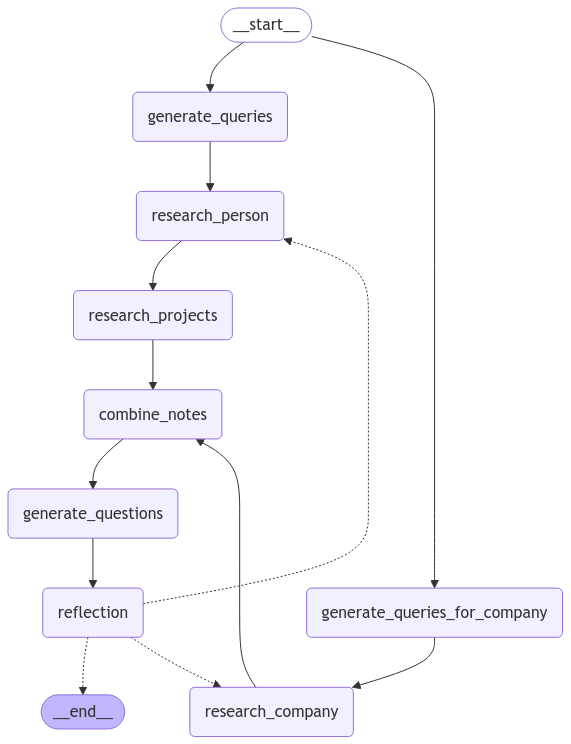

In [162]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the compiled StateGraph as a Mermaid diagram
display(Image(graph.get_graph().draw_mermaid_png()))

## What is LangGraph Studio
![Using LangGraph Studio](./assets/20-LangGraphStudio-MultiAgent-02.png)

# How to connect a local agent to LangGraph Studio

**Connection Options**
There are two ways to connect your local agent to LangGraph Studio:

- [Development Server](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#development-server-with-web-ui): Python package, all platforms, `no Docker`
- [LangGraph Desktop](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#desktop-app): `Application`, `Mac only`, `requires Docker`

In this guide we will cover how to use the development server as that is generally an easier and better experience.


[LangGraph Studio Desktop (Beta)](https://github.com/langchain-ai/langgraph-studio)

The desktop application only supports macOS. Other users can [run a local LangGraph server and use the web studio](https://langchain-ai.github.io/langgraph/tutorials/langgraph-platform/local-server/#langgraph-studio-web-ui). We also depend on Docker Engine to be running, currently we only support the following runtimes:

[LangGraph Studio Download for MacOS](https://studio.langchain.com/)

### Setup your application

First, you will need to setup your application in the proper format. This means defining a langgraph.json file which contains paths to your agent(s). See [this guide](https://langchain-ai.github.io/langgraph/concepts/application_structure/) for information on how to do so.

## TODO
1. langgraph 연결
2. ipynb -> py 파일 변환 코드 추가
3. 데모 추가 
4. agent 설명추가~
5. usage examples 추가 (advanced agent)